# Screening Task 1 for QOSF Mentorship

### How can we know that two quantum states are close?

This task inspired me to propose a project that can be end in a blog post about the different metrics out there for measuring the closeness between two quantum states.

Since this task is about about finding the optimal parameters of a Quantum Circuit in order to optimize a distance between the output state of the Quantum Circuit and a target quantum state, this opens a fundamental question in the theory of quantum mechanics about the feasibility of defining a distance metric between quantum states.

Here we are going take a little dive in into the concept of quantum states and distance metrics between them.

## Problem statement

The idea of task 1 is to implement the following variational circuit that prepares a 4 qubit state $| \Psi(\theta)\rangle$

<img src="images/circuit1.jpg">

Here, we call as a layer to the combination of an odd block (yellow) and an even block (green). The number of layers denoted by $L$ is an hyperparameter of the variational circuit.

Specifically, each block is defined as follows:

                                             Odd block
<img src="images/odd_block.jpg" style="width:350px;height:150px"/>

                                             Even block
<img src="images/even_block.jpg" style="width:500px;height:150px"/>

Where the double qubits gates are $CZ$ gates and a layer of the variational circuit is composed by 8 parameters denoted by $\theta_{i, n}$ (4 parameters per block).

The idea is to report with a plot, as a function of the number of layers, the minimum distance

$\varepsilon = min_{\theta}\left \| |\Psi(\theta) - \phi \rangle \right \|$

Where $|\phi\rangle$ is a randomly generated vector of 4 qubits, i.e. 16 dimensions, and $\left \| v \rangle \right \| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$. The right set of parameters $\theta_{i, n}$ can be found via any method of choice.

You can go to the source document where all the screening tasks are explained and discussed <a href="https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit" target="_blank">here</a>.

## Overview of this work

This work is organized as follows:

1. Generate a proper random quantum state, its probability vector, density matrix and quantum fidelity.


2. Building the variational quantum circuit using `Qiskit`.


3. Optimization of the variational circuit in `Qiskit Aer StatevectorSimulator` backend `COBYLA` optimizer. Minimizing the Euclidean distance of two complex vectors.


4. Optimization of the variational circuit in `Qiskit Aer QasmSimulator` backend `COBYLA` optimizer. Minimizing the diagonal terms of two density matrices or minimizing the probability distribution of the outcomes in a given basis.


5. Building the variation quantum circuit using `Pennylane`.


6. Optimizating Quantum Fidelity in `Pennylane` using `GradientDescentOptimizer` optimizer. Maximizing the quantum fidelity between two quantum states or maximizing the probability of observing the system to be in a target quantum state.


If you want to know more about the difference and capabilities of Qiskit simulators take a look to <a href="https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html" target="_blank">Qiskit Aer Simulators.</a>

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Define some useful plot functions

In [2]:
def plot_density_matrix(n_layers: int, params: np.array):
    """The aim of this function is to visualize the output
    density matrix of the final state given by the Quantum
    Variational Circuit simulated in StatevectorSimulator.
    
    Arguments:
        n_layers (int): number of layers in the 
            Variational Circuit.
            
        params (np.array): np.array with the parameters
            of the Variational Circuit.
    """
    
    qc = build_variational_circuit(n_layers, params)
    backend = Aer.get_backend('statevector_simulator')
    statevector = execute(qc, backend).result().get_statevector(qc, decimals = 3)

    return plot_state_city(statevector, title=f'State after optimization of a {n_layers} layer variational circuit')
    
def plot_measurements(n_layers: int, params: np.array):
    """The aim of this function is to visualize the output
    histogram of the final state given by the Quantum
    Variational Circuit simulated in QasmSimulator.
    
    Arguments:
        n_layers (int): number of layers in the 
            Variational Circuit.
            
        params (np.array): np.array with the parameters
            of the Variational Circuit.
    """
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    return plot_histogram(counts, title=f'State counts after optimization of {n_layers} layer circuit')

## Generating a proper random quantum state, its probability vector and distance metrics

1. A pure quantum state is a complex vector denoted as $|\psi\rangle$.


2. A more general definition of a quantum state is the density matrix $\rho$. 


3. For a pure quantum state its density matrix is $\rho = |\psi\rangle\langle \psi|$.


4. The diagonal terms of the density matrix are the probabilities associated to measuring the state in the basis in which is represented. $P(n) = \rho_{nn}$


5. Quantum Fidelity is a popular measure of distance between density operators. It is not a metric, but has some useful properties and it can be used to defined a metric on this space of density matrices, known as Bures metric. <a href="https://www.quantiki.org/wiki/fidelity" target="_blank">Explore more about Quantum Fidelity.</a>


6. In the case of two pure states i.e. $\rho = |\psi\rangle\langle \psi|$ and $\sigma = |\phi\rangle\langle \phi|$, the Fidelity is $F(\rho, \sigma) = |\langle \psi|\phi\rangle|^2$. This is also the probability of observing the system to be in state $|\phi\rangle$ given that it is in the state $|\psi\rangle$.

In [3]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int, amplitude_type: str = 'complex') -> np.array:
    """Creates a normalized random real or complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
        amplitude_type (str): string indicating if you want to create a
            vector with 'complex' or 'real' number amplitudes.
            
    Returns:
        (np.array): normalized real or complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    if amplitude_type == 'complex':
        Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #generate an unnormalized real vector of dimension = dim
    elif amplitude_type == 'real':
        Z = np.random.random(dim)
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of the respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))
    
def density_matrix(target_vector: np.array) -> np.array:
    """Return the density matrix of a pure state.
    
    Arguments:
        target_vector (np.array): Complex vector array.
        
    Returns:
        (np.array): Density matrix of shape (dim, dim),
            where dim is the dimension of the target_vector.
    """
    target_vector_reshape = target_vector.reshape((target_vector.shape[0],1))
    density_matrix = target_vector_reshape @ np.transpose(np.conjugate(target_vector_reshape))
    
    return density_matrix

def quantum_fidelity(v1: np.array, v2: np.array) -> float:
    """Returns the Quantum Fidelity of two pure
    states.
    
    Arguments:
        v1 (np.array): First complex vector array.
        
        v2 (np.array): Second complex vector array.
        
    Returns:
        (float): Quantum fidelity between two complex vectors.
    """
    v1_reshape = v1.reshape((v1.shape[0], 1))
    v2_reshape = v2.reshape((v2.shape[0], 1))
    
    inner_product = np.transpose(np.conjugate(v1_reshape)) @ v2_reshape
    
    return np.square(np.absolute(inner_product))[0][0]

## Some checks to the functions defined

In [4]:
#Remember that a n-qubit quantum state is a vector of dim = 2^n_qubits
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)
psi

tensor([0.53258765+0.27020328j, 0.79056025+0.13548092j], requires_grad=True)

In [5]:
get_probabilities(psi)

tensor([0.35665942, 0.64334058], requires_grad=True)

In [6]:
#Quantum fidelity of the same state must be 1.0
quantum_fidelity(psi, psi)

0.9999999999999996

In [7]:
#Quantum fidelity of orthogonal states must be zero.
v1 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
v2 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
quantum_fidelity(v1, v2)

0.0

## Building the variational quantum circuit in Qiskit

In [8]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    """Build the variational quantum circuit with a defined
    number of layers.
    
    Arguments:
        number_layers (int): number of layers that we want.
        
        params (np.array): np.array of shape (8*number_layers,)
            with the set of angles for the complete variational
            circuit.
            
    Returns:
        (QuantumCircuit): QuantumCircuit object from Qisikit.
            This is our variational quantum circuit.
    """
    
    #number of parameters depending on the number of layers-
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc

def layer(qc: QuantumCircuit, params: np.array) -> None:
    """A layer is defined by a combination of an
    odd block and an even block. First we apply the odd 
    block to the Quantum Circuit and then the even block.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the two blocks.
        
        params (np.array): np.array of shape (8,) with the angles
            for each block.
    
    Returns:
        (None)
    """
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RX to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RX gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RZ and CZ to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RZ gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

## Let's check out our Variational Circuit!

In [9]:
#Some parameters to visualize our variational circuit.
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

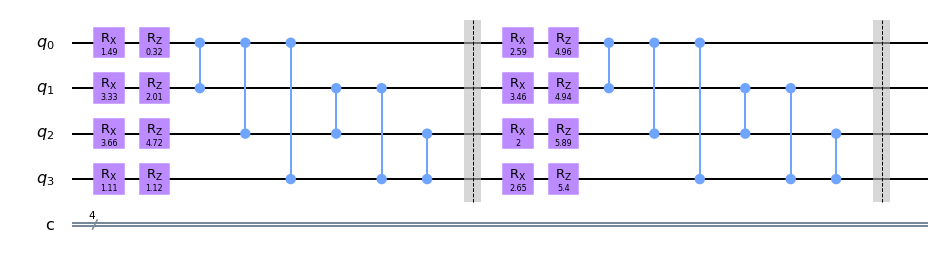

In [10]:
#Show me that circuit!
qc.draw(output='mpl')

In [11]:
#Let's check that the execution runs properly.
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[-0.01994662+0.43064251j  0.20894208-0.11143508j  0.03149564-0.04359043j
 -0.00310355-0.00339835j -0.20504803+0.03479639j -0.07270453+0.04517743j
 -0.03540364-0.00800326j  0.00586598-0.02490377j  0.04214444-0.27361964j
  0.07940063+0.5813287j  -0.03416641-0.02021336j  0.03567546-0.10660851j
 -0.0679198 +0.22863731j -0.42805057+0.11146354j  0.00058703-0.06565653j
 -0.1031692 +0.00261687j]


## Function definitions to use in our optimization routines

In [12]:
def get_outputstate(n_layers: int, params: np.array) -> np.array:
    """Obtain the output state of the variational circuit
    with the given parameters. This must be executed in the
    statevector_simulator.
    
    Arguments:
        n_layers (int): number of layers in the 
            Variational Circuit.
            
        params (np.array): np.array with the parameters
            of the Variational Circuit.
            
    Returns:
        (np.array): output vector state of the circuit
            with the given parameters.
        
    """
    
    backend = Aer.get_backend('statevector_simulator')
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    return outputstate

def get_measurement(n_layers, params):
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    
    return counts
    

def norm_vector_difference(params):

    outputstate = get_outputstate(n_layers, params)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    """Square error between two probability vectors.
    """
    
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.square(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

## Random target quantum state initialization.

In [13]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

## Optimization using `Qiskit Aer StatevectorSimulator`

Since we are going to optimize the norm of the difference between the output state of the variational circuit and the target vector state we must get access to the complete output state of the circuit which can be simulated in the `StatevectorSimulator` in Qiskit. However, remember that this is just a simulation and it's not reliable in a real experiment since we are dealing with measurements to obtain information of just a portion of the complete state, unless you define an experiment to make <a href="https://en.wikipedia.org/wiki/Quantum_tomography" target="_blank">Quantum Tomography</a> of the output state which is the beautiful art of reconstructing a quantum state by doing measurements.

## Optimization routine with different number of layers using COBYLA

In [14]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Empty lists to save results
cost_list = []
params_list = []
#Iterate over different number of layers
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    #Initial parameters
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Vector:", target_vector)
        print("Obtained Vector:", final_vector)
        print("Norm difference:", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Vector: [0.03622226+0.02989604j 0.25235196+0.25754724j 0.11535862+0.18777344j
 0.02976996+0.19815387j 0.03821173+0.22166285j 0.06892016+0.24003446j
 0.12967319+0.14728451j 0.17360738+0.03564749j 0.24235557+0.19534352j
 0.18072638+0.1840984j  0.10164081+0.26214436j 0.12489835+0.17381046j
 0.24061207+0.12296457j 0.25865384+0.23787086j 0.12098929+0.16454545j
 0.18440378+0.18883393j]
Obtained Vector: [-0.24002043+0.j          0.23353918+0.26689695j  0.10318286+0.17791823j
 -0.09744417+0.28785079j  0.08494884+0.18909614j -0.12761539+0.27845106j
 -0.10365113+0.14426034j  0.26126627-0.02510733j  0.13576843+0.1664526j
 -0.052989  +0.31292913j -0.06501937+0.17219674j  0.25474229-0.09524695j
 -0.08308532+0.16587439j  0.26529011-0.06900642j  0.15867424-0.00972001j
  0.16519799+0.1669844j ]
Norm difference: 0.8082686426920991
Parameters Found: [ 8.23482569  1.41697263  4.85841994  4.82317298  5.56434607 -0.52554294
  2.71937407  2.45737667]

Number of layers: 4
Target Ve

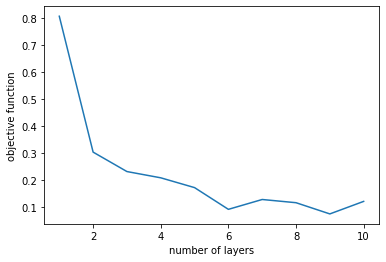

In [15]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

### Show me the results!

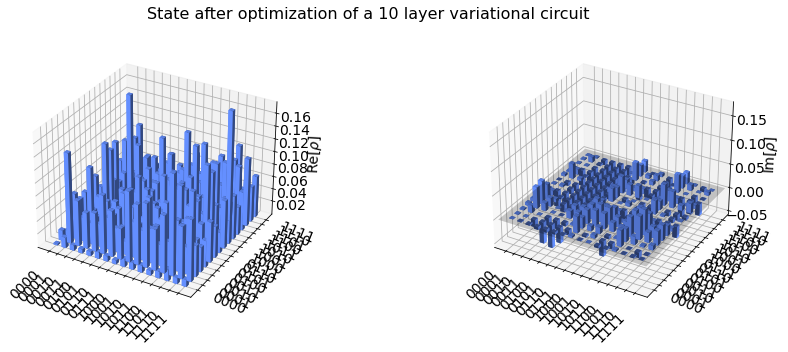

In [16]:
plot_density_matrix(10, params_list[9])

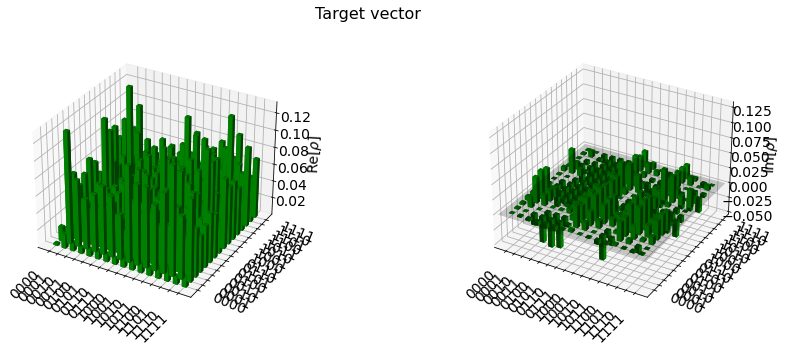

In [17]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

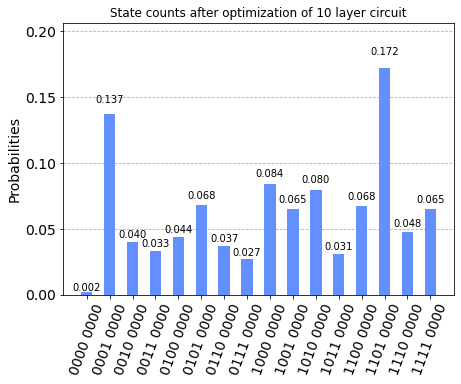

In [18]:
plot_measurements(10, params_list[9])

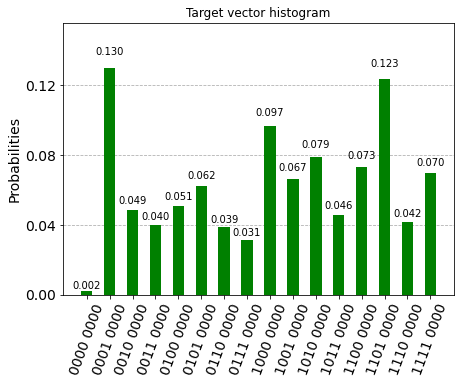

In [19]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

### Metrics obtained minimizing the norm of the vector difference

In [20]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 0.12176020603278154
Quantum fidelity: 0.9854703234155484


## Optimization using `Qiskit Aer QasmSimulator`

Now we are going to perform a more reliable experiment that is going to show us the limitations of solving this task in a real quantum device. We are going to measure the output state of the circuit in a given basis, so we are going to have access to just the diagonal terms of its density matrix (just a portion of the state) and then optimize the routine to get close to the diagonal terms of the density matrix of the target quantum state (just a portion of the state). To reconstruct the whole output state we have to re-think our experiment as a Quantum Tomography process in which we have to make a lot more measurements in different basis and rotations of the state.

## Optimization routine with different number of layers using COBYLA

In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Empty lists to save results
n_parameters_per_layer = 8
cost_list = []
params_list = []
# Iterate over different number of layers
for n_layers in range(1,11):
    # Initial parameters
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Distribution:", target_distr)
        print("Obtained Distribution:", output_distr)
        print("Output Error (square-error):", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Distribution: [0.00220583 0.13001209 0.04856648 0.04015121 0.05059456 0.06236653
 0.03850786 0.03141027 0.09689531 0.06655424 0.07905052 0.04580967
 0.07301446 0.12348436 0.04171361 0.069663  ]
Obtained Distribution: [0.0498 0.066  0.0343 0.0458 0.0528 0.0679 0.0312 0.0403 0.0794 0.1042
 0.0532 0.0719 0.0791 0.1045 0.05   0.0696]
Output Error (square-error): 0.010162263875518085
Parameters Found: [1.72798675 1.35629214 1.57370155 4.49196314 2.06906933 2.55870993
 4.55437054 0.27901488]

Number of layers: 4
Target Distribution: [0.00220583 0.13001209 0.04856648 0.04015121 0.05059456 0.06236653
 0.03850786 0.03141027 0.09689531 0.06655424 0.07905052 0.04580967
 0.07301446 0.12348436 0.04171361 0.069663  ]
Obtained Distribution: [0.0103 0.1287 0.0511 0.0496 0.0664 0.0631 0.0386 0.026  0.0943 0.0713
 0.0737 0.0106 0.0729 0.1162 0.0413 0.0859]
Output Error (square-error): 0.0021276107772914225
Parameters Found: [7.20682423 6.16849945 4.2865215  5.61479228 2.144297

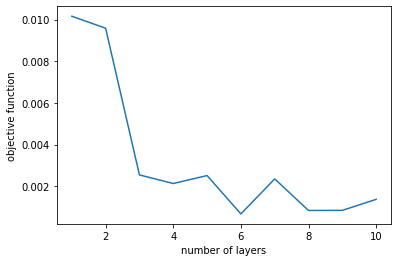

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

### Show me the results!

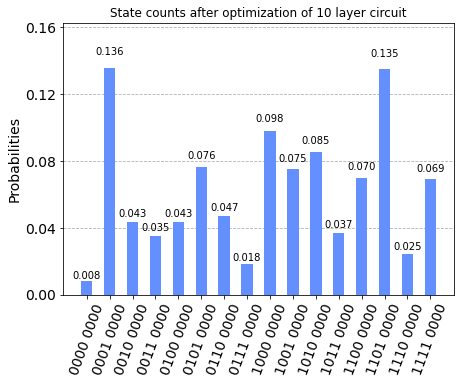

In [23]:
plot_measurements(10, params_list[9])

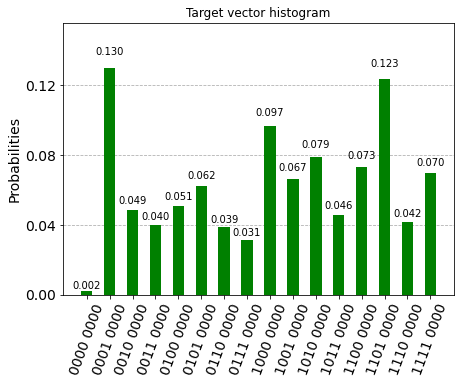

In [24]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

### Metrics obtained minimizing the square error of the probability distributions

In [25]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 1.3742023743616438
Quantum fidelity: 0.19880174969922837


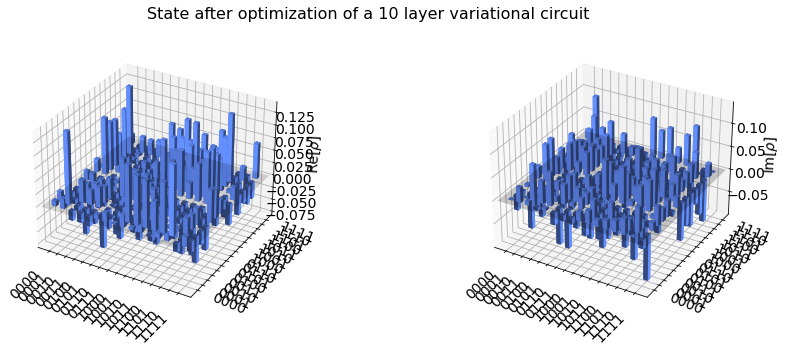

In [26]:
plot_density_matrix(10, params_list[9])

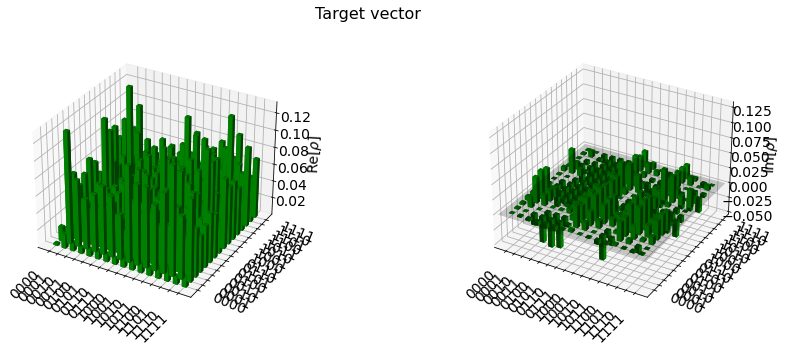

In [27]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

## Optimize the variational circuit using Pennylane and Quantum Fidelity as a "metric"

This beautiful <a href="https://arxiv.org/pdf/0905.0114.pdf" target="_blank">paper</a> from the Nobel laureate Serge Haroche group define a measureble distance in a real quantum experiment.

A distance is defined by using the Quantum Fidelity:

$V(\theta) = 1 - |\langle \Psi(\theta)|\phi\rangle|^2$.

And remember that in Quantum Mechanics the expectation value of an observable $A$ is determined by:

$\langle A\rangle = \langle \psi|A| \psi\rangle$,

where $A$ is an operator (a matrix).

But what happens if we define our observable as the density matrix of our target state $\rho = |\phi\rangle\langle \phi |$. We get:

$\langle \rho\rangle = \langle \Psi(\theta|\phi\rangle\langle \phi| \Psi(\theta\rangle = |\langle \Psi(\theta)|\phi\rangle|^2$

Which is the Quantum Fidelity! A real observable in a quantum experiment.

In [28]:
dev = qml.device('default.qubit', wires = 4)

## Define density matrix of the target vector to be measured

In [29]:
density_matrix = density_matrix(target_vector)

## Build the variational circuit in Pennylane

I had problems using of <a href="https://pennylaneqiskit.readthedocs.io/en/latest/" target="_blank">Pennylane-Qiskit plugin</a> for re-using the Variational Circuit defined in Qiskit, so let's build the circuit in Pennylane instead.

In [30]:
def layer_pennylane(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block_pennylane(params[:int(n_parameters/2)])
        even_block_pennylane(params[int(n_parameters/2):])

def odd_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [31]:
@qml.qnode(dev)
def var_circuit(params):
    """Build the variational circuit with the 
    target density matrix as the measurable observable.
    Hence, this circuit is going to return the Quantum Fidelity
    between the output state of the circuit and the target state.
    """

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer_pennylane(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [32]:
def cost(x):
    """Cost function defined as the distance
    metric using the Quantum Fidelity.
    """
    
    return (1.0 - var_circuit(x))

## Let's check our functions.

In [40]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

circ = var_circuit(params)
print(f"Norm of the difference: {norm(dev.state - target_vector)}")
print(f"Quantum Fidelity: {quantum_fidelity(dev.state, target_vector)}")

Norm of the difference: 1.38917341374902
Quantum Fidelity: 0.05140724566170438


## Optimization routine with different number of layers using Gradient Descent

In [34]:
cost_list = []
params_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))
    params_list.append(params)

0.4811613331090646
0.08076985596311692
0.040001732532643386
0.019480206608679107
0.001204698795708059
0.00041264938956642183
0.00186787658048726
1.355427803328979e-06
3.4056722691966357e-06
2.8055912038027486e-09


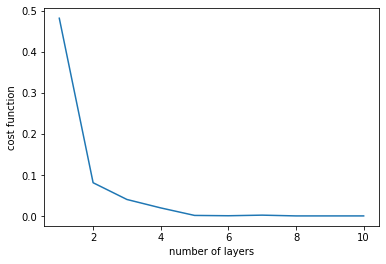

In [35]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()

### Metrics obtained minimizing the distance defined by the Quantum Fidelity

In [36]:
circuit = var_circuit(params_list[9])
output_state = dev.state
print(f"Norm of the differece: {norm(output_state - target_vector)}")
print(f"Quantum Fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the differece: 0.2338006691719511
Quantum Fidelity: 0.9999999971944094


### Show me the results!

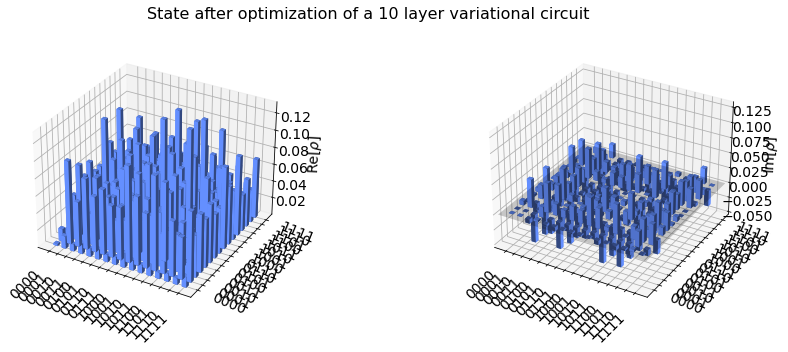

In [43]:
plot_density_matrix(10, params_list[9])

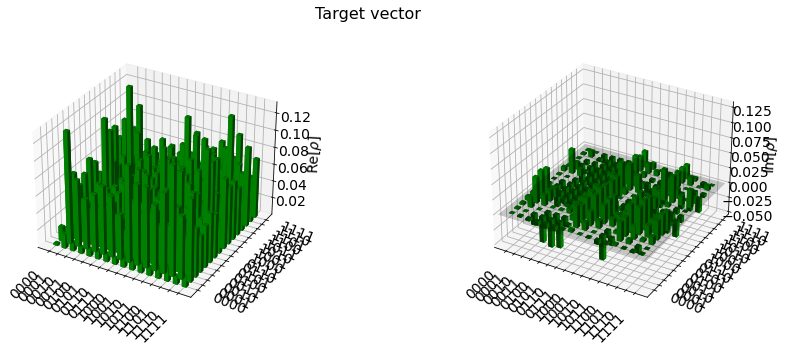

In [44]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

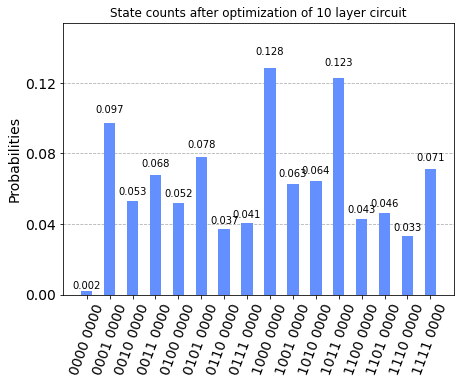

In [37]:
plot_measurements(10, params_list[9])

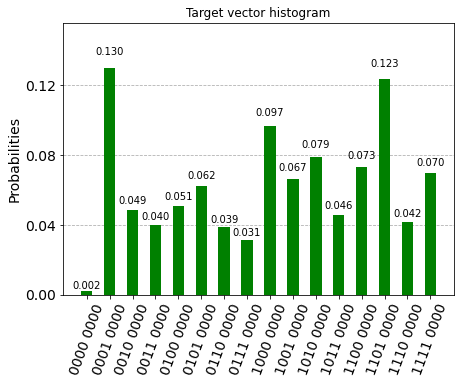

In [38]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

## Conclusions

We showed and analyzed in a simple experiment some beautiful concepts about the theory of quantum mechanics such as quantum states, quantum measurements and the difficulty of achieving an optimization routine for generating a target vector in a real quantum realm.

This work can be followed with more experiments that can end in a blog post about the impact of using different metrics to measure the closeness of two quantum states. Also, we can in the future explore the differences in the mathematical definitions of these metric distances.

More technical things can be explored about the optimization techniques and defining different circuit architectures to obtain better expressibility.

Cheers!